# Assignment 1

I have decided to focus on rythm/tempo in midi-files because it might relate best to my Master Thesis (Drummer "AI"), and therefore I would like to delve a little deeper into this topic. I dont know yet how to properly read all the results, or what I should be looking for (or where this topic will lead me), but for now I was kind of interested in seeing how tempo changes could separate the different composers. I got 7 features related to tempo/beats/notes. I was hoping to see more direct time_signature_changes, but that did not seem to be that usual in these midi files. I did however notice when loading the midi files in Logic, that the tempo was constantly changing to simulate dynamic playing. I was thinking that maybe this could be discernable between the composers, like if bethooven has a lot of notes that sometimes gets played really fast, that would be quite different from e.g grieg which would have more constant tempo and fewer notes. Without too much prior knowlegde of classical composers, I would assume the mean tempo of mozart and bethooven with be higher than tchaikovsky and grieg, and I do think this also comes out in the visualization of the data. 
Looking at the features analysis (figure 32, or just run the program), it seems there is a biggest spread in Total Notes, Total Tempo Changes, Total Control Changes and Mean Tempo, while the other feature might be too similar between the composers. It would be nice if e.g Bethooven always had more notes and higher tempo (which seems to be true for many of his compositions), making it easy to group/cluster him, but there also seems to be a big variation between the songs for each composer as well. There are probably many more factors/features I could be looking into in the future. I guess these features are kind of basic?

Even though I cant say ive gotten any good absolute values of the perfomances, it seems k-NN have had the best precision % of the classifiers that I have chosen. I have shorted down the dataset i have used in /.data/midi so it might be a little small, but I didnt want to add to many outliers/noise, and maybe try to be able to easy visualize the data (/try to understand what im looking at). 
I think I would have more songs per composer rather than adding to many composers (?). I have also added the full dataset the group has made in data/fullmidi to get feedback on.

I have added a extra cell to visualize/analyse the features, and i have a cell i used to look into specific midi files to experiment with to understand what content was available in the midi files.

# Requirements
I have not added any extra requirements, as most of my code has been taken from the workshops. It should run fine under a conda python 3.11 environment.

Done!

Training MLP Classifier...
Accuracy of MLP Classifier: 0.2857
Classification Report:
              precision    recall  f1-score   support

       grieg       0.40      0.50      0.44         4
          mz       0.25      0.33      0.29         3
          ty       0.00      0.00      0.00         3
          be       0.25      0.25      0.25         4

    accuracy                           0.29        14
   macro avg       0.23      0.27      0.25        14
weighted avg       0.24      0.29      0.26        14



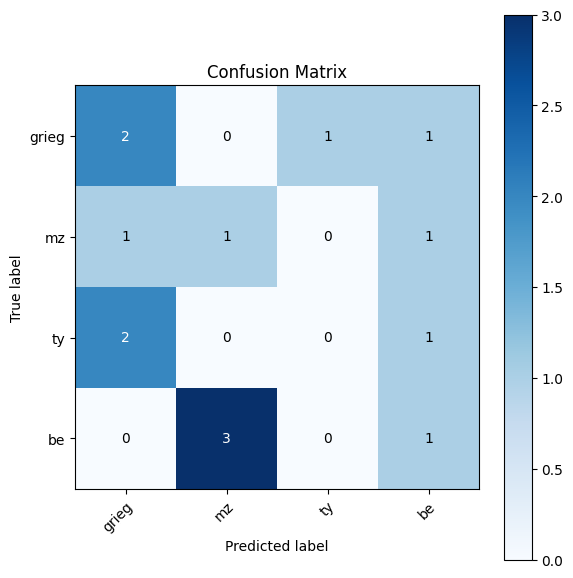


Training Logistic Regression...
Accuracy of Logistic Regression: 0.2857
Classification Report:
              precision    recall  f1-score   support

       grieg       0.43      0.75      0.55         4
          mz       0.17      0.33      0.22         3
          ty       0.00      0.00      0.00         3
          be       0.00      0.00      0.00         4

    accuracy                           0.29        14
   macro avg       0.15      0.27      0.19        14
weighted avg       0.16      0.29      0.20        14



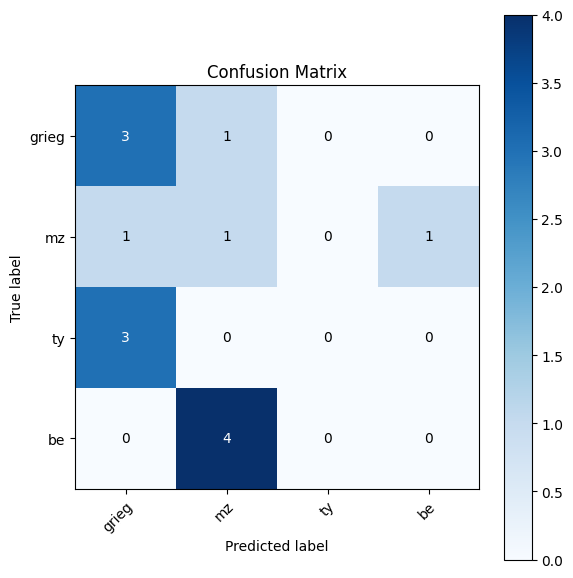


Training SVC...
Accuracy of SVC: 0.3571
Classification Report:
              precision    recall  f1-score   support

       grieg       0.38      0.75      0.50         4
          mz       0.33      0.33      0.33         3
          ty       0.00      0.00      0.00         3
          be       0.33      0.25      0.29         4

    accuracy                           0.36        14
   macro avg       0.26      0.33      0.28        14
weighted avg       0.27      0.36      0.30        14



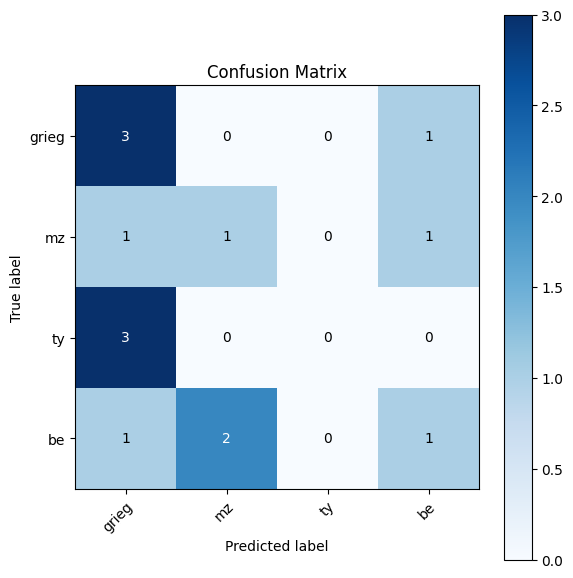


Training K Nearest Neighbors...
Accuracy of K Nearest Neighbors: 0.2857
Classification Report:
              precision    recall  f1-score   support

       grieg       0.33      0.50      0.40         4
          mz       0.20      0.33      0.25         3
          ty       0.00      0.00      0.00         3
          be       0.50      0.25      0.33         4

    accuracy                           0.29        14
   macro avg       0.26      0.27      0.25        14
weighted avg       0.28      0.29      0.26        14



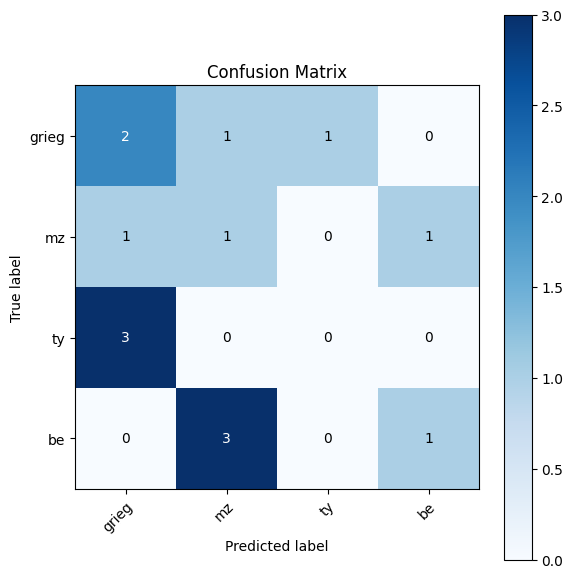


Training Gaussian Naive Bayes...
Accuracy of Gaussian Naive Bayes: 0.2857
Classification Report:
              precision    recall  f1-score   support

       grieg       0.33      0.50      0.40         4
          mz       0.33      0.33      0.33         3
          ty       0.00      0.00      0.00         3
          be       0.25      0.25      0.25         4

    accuracy                           0.29        14
   macro avg       0.23      0.27      0.25        14
weighted avg       0.24      0.29      0.26        14



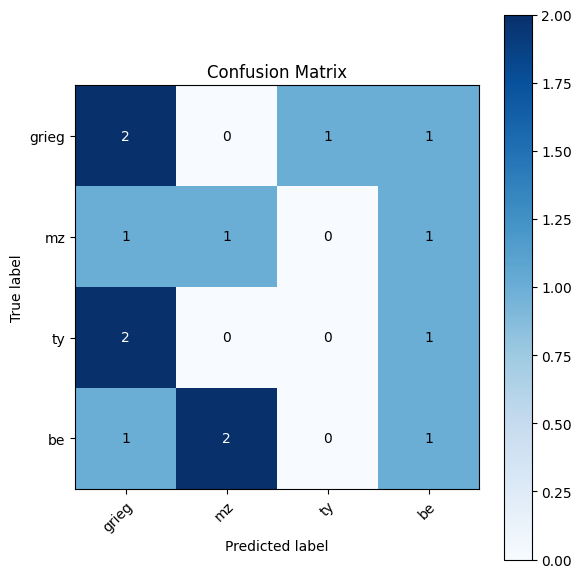

In [7]:
# Importing packages
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import os
# import scikit-learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Extract features
def extract_midi_features(midi_file):
    pm = pretty_midi.PrettyMIDI(midi_file)
    
    total_notes = sum(len(instr.notes) for instr in pm.instruments if not instr.is_drum)
    num_tempo_changes = len(pm.get_tempo_changes()[0]) - 1  # Subtract 1 since the first tempo is the initial tempo, not a change
    total_control_changes = sum(len(instr.control_changes) for instr in pm.instruments)
    total_time_signature_changes = len(pm.time_signature_changes)
    
    # Calculate the mean tempo from the tempo changes
    tempos = pm.get_tempo_changes()[1]
    mean_tempo = np.mean(tempos) if len(tempos) > 0 else 0  # Default to 0 if no tempo changes

    # Get the number of beats and their intervals
    beats = pm.get_beats()
    if len(beats) > 1:
        beat_intervals = np.diff(beats)
        mean_beat_interval = np.mean(beat_intervals)
        std_beat_interval = np.std(beat_intervals)
    else:
        mean_beat_interval, std_beat_interval = 0, 0  # Default values if not enough beats

    # Calculate the average notes per bar
    if pm.time_signature_changes:
        time_signature = pm.time_signature_changes[0]
        beats_per_bar = time_signature.numerator  
    else:
        beats_per_bar = 4  # Default to common time if no time signature changes are found
    
    total_bars = len(beats) / beats_per_bar if beats_per_bar else 0
    average_notes_per_bar = total_notes / total_bars if total_bars else 0

    # Calculate the average notes per minute
    total_duration_minutes = pm.get_end_time() / 60
    average_notes_per_minute = total_notes / total_duration_minutes if total_duration_minutes else 0

    return {
        "num_tempo_changes": num_tempo_changes,
        "total_control_changes": total_control_changes,
        "total_time_signature_changes": total_time_signature_changes,
        "mean_tempo": mean_tempo,
        "mean_beat_interval": mean_beat_interval,
        "std_beat_interval": std_beat_interval,
        "average_notes_per_bar": average_notes_per_bar,
    }
# Creating an array of zeros of the proper size where we will store computed features and labels
filenames = os.listdir('./data/midi')
features = np.zeros((len(filenames), 7))  # Adjusted comment to match the feature extraction
labels = np.zeros((len(filenames)))  # Store the labels as integers
classes = ['grieg', 'mz', 'ty', 'be']  # List of text labels to convert numerical labels to text labels

for i, filename in enumerate(filenames):
    # Extract features
    feature_dict = extract_midi_features(os.path.join('./data/midi', filename))
    

    feature_values = [
        feature_dict["num_tempo_changes"],
        feature_dict["total_control_changes"],
        feature_dict["total_time_signature_changes"],
        feature_dict["mean_tempo"],
        feature_dict["mean_beat_interval"],
        feature_dict["std_beat_interval"],
        feature_dict["average_notes_per_bar"],
    ]
    
    # Assign to the features array
    features[i, :] = feature_values
    
    # Label assignment logic
    if 'grieg' in filename:
        labels[i] = 0
    elif 'mz_' in filename:
        labels[i] = 1
    elif 'ty_' in filename:
        labels[i] = 2
    elif 'be_' in filename:
        labels[i] = 3

print('Done!')

#splitting the dataset in training and testing parts
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.2, random_state=17)

# List of classifiers to evaluate
classifiers = [
    ('MLP Classifier', MLPClassifier(hidden_layer_sizes=(5,5), max_iter=10000, activation='relu')),
    ('Logistic Regression', LogisticRegression(max_iter=10000)),
    ('SVC', SVC()),
    ('K Nearest Neighbors', KNeighborsClassifier()), 
    ('Gaussian Naive Bayes', GaussianNB())  
]


for name, classifier in classifiers:
    # Define the pipeline with the current classifier
    # setting up a pipeline for each classifier, which includes scaling (to normalize features), 
    # dimensionality reduction (to reduce the number of features while retaining most of the variance),
    #  and the classification algorithm itself.
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('dim_red', PCA(n_components=0.99)),  # Adjust PCA to retain 99% of variance, ive tried varying this to varying results
        ('classifier', classifier)
    ])
    
    # Training the pipeline
    print(f"\nTraining {name}...")
    pipe.fit(feat_train, lab_train)
    
    # Applying the trained pipeline
    lab_predict = pipe.predict(feat_test)
    
    # Evaluation metrics
    accuracy = accuracy_score(lab_test, lab_predict)
    print(f"Accuracy of {name}: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(lab_test, lab_predict, target_names=classes, zero_division=0))
    

    # Compute Confusion matrix
    conf_mat = confusion_matrix(lab_test, lab_predict)
    # Confusion Matrix Visualization 
    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.imshow(conf_mat, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(cax, ax=ax)
    ax.set(xticks=np.arange(conf_mat.shape[1]),
        yticks=np.arange(conf_mat.shape[0]),
        xticklabels=classes, yticklabels=classes,
        title='Confusion Matrix',
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


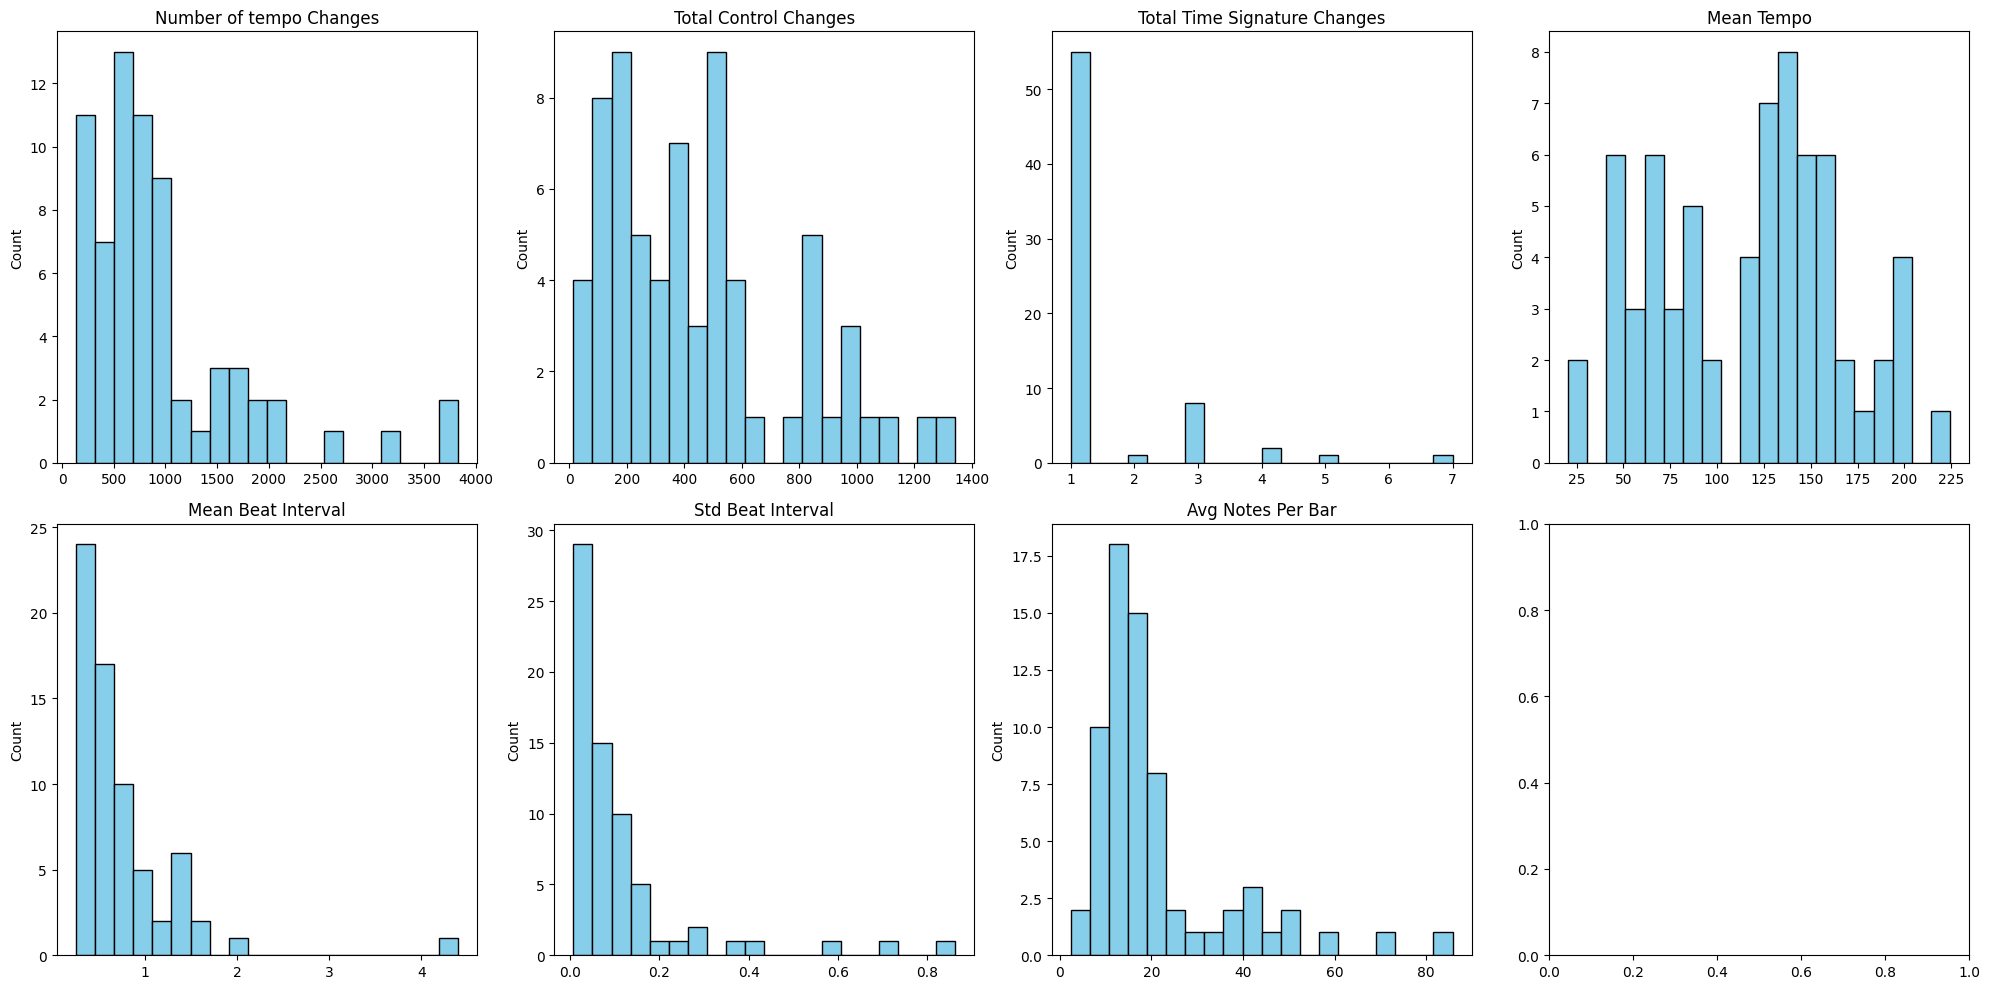

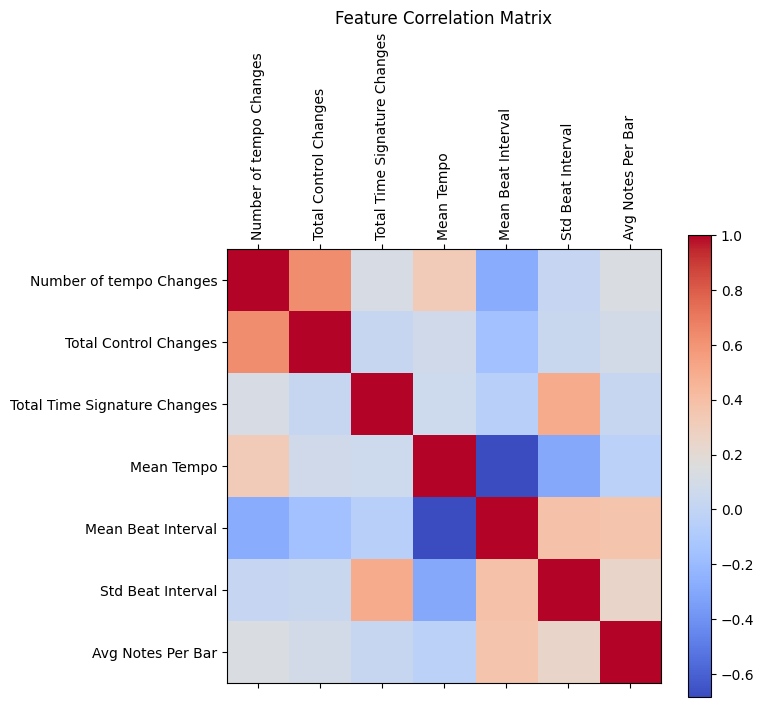

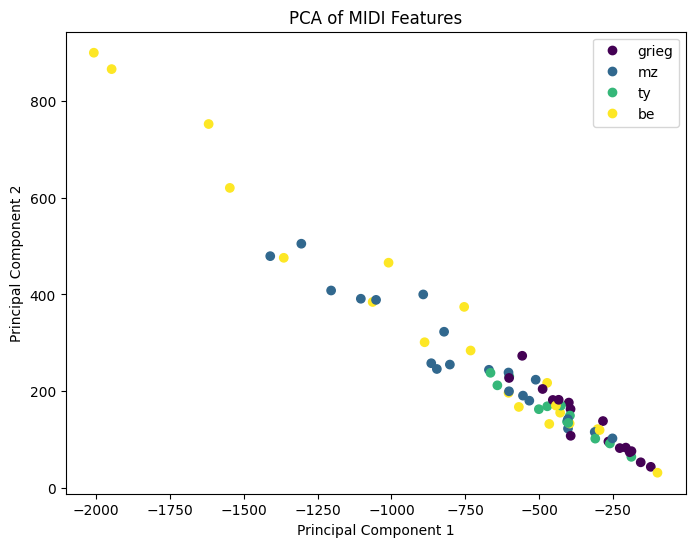

In [8]:
# Visualization
# Visualize feature distributions
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.ravel()
feature_names = ['Number of tempo Changes', 'Total Control Changes', 'Total Time Signature Changes', 'Mean Tempo', 'Mean Beat Interval', 'Std Beat Interval', 'Avg Notes Per Bar' ]

for i, ax in enumerate(axes[:7]): 
    ax.hist(features[:, i], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(feature_names[i])
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# Visualize feature correlations
corr = np.corrcoef(features, rowvar=False)
fig, ax = plt.subplots(figsize=(7, 6))
cax = ax.matshow(corr, cmap='coolwarm')
fig.colorbar(cax)
ax.set_xticks(np.arange(len(feature_names)))
ax.set_yticks(np.arange(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=90)
ax.set_yticklabels(feature_names)
plt.title('Feature Correlation Matrix')
plt.show()


# Visualization of PCA that has been applied to visualize 2 principal components
pca_features = pipe['dim_red'].transform(features)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of MIDI Features')
plt.show()





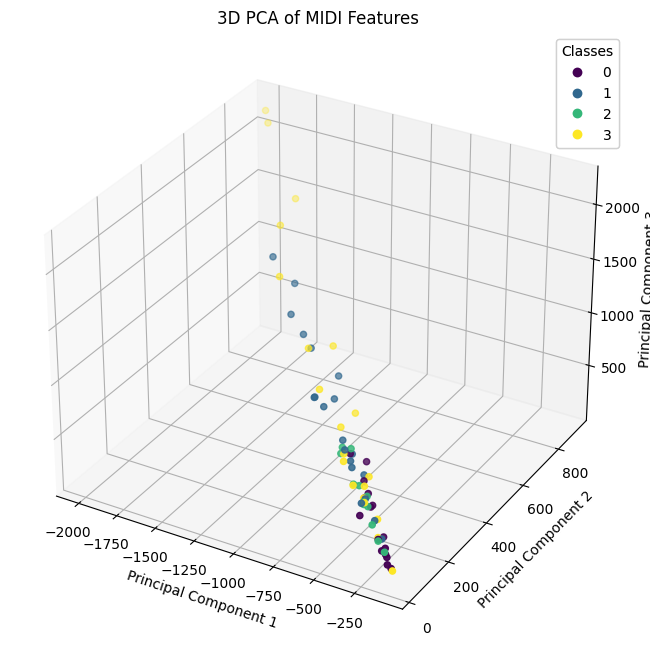

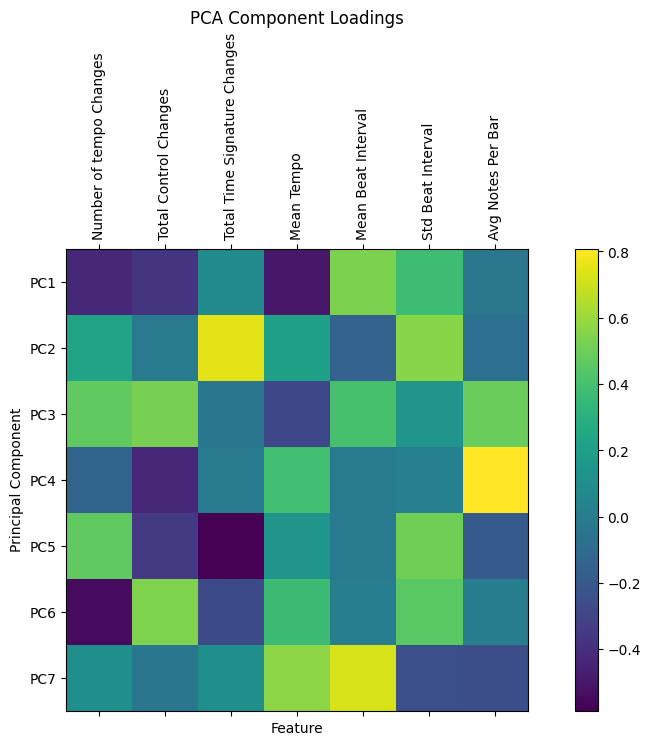

In [9]:
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Assuming PCA has been applied and you want to visualize the first 3 principal components
pca_features = pipe['dim_red'].transform(features)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot

# Scatter plot using the first three PCA components
scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], pca_features[:, 2], c=labels, cmap='viridis')

# Generate a legend with class labels
legend = ax.legend(*scatter.legend_elements(), title="Classes",  loc="upper right") # "labels=classes," didnt work here for some reason? But I seems the colorschemes are the same as in the 2d plot
ax.add_artist(legend)

# Set labels for axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Set title
ax.set_title('3D PCA of MIDI Features')

plt.show()

# Create a heatmap for the PCA component loadings
pca_loadings = pipe['dim_red'].components_
fig, ax = plt.subplots(figsize=(12, 6))
cax = ax.matshow(pca_loadings, cmap='viridis')
fig.colorbar(cax)

# Set ticks and labels
ax.set_xticks(np.arange(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=90)
ax.set_yticks(np.arange(pca_loadings.shape[0]))
ax.set_yticklabels([f"PC{i+1}" for i in range(pca_loadings.shape[0])])

plt.title('PCA Component Loadings')
plt.xlabel('Feature')
plt.ylabel('Principal Component')
plt.show()